In [1]:
import json
import os.path

import altair as alt
import teammachine as tm

# Altair configuration
# Comment this line if using Jupyter Lab instead of a plain notebook
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [2]:
# Construct a teammachine Client with credentials downloaded from https://app.teammachine.io/spaces/api-clients
with open('/Users/matti/Projects/team-machine/auth/dogfood-credentials.json') as f:
    credentials = json.load(f)
    
client = tm.Client(
    authorization_url='https://svc.teammachine.io/svc/v1/tokens', 
    query_url='https://query.teammachine.io/query', 
    **credentials
)

In [3]:
# At teammachine we use Weave Works (https://www.weave.works/) for releasing our Kubernetes services
# so an indicator of a deployment is a change to a file in the "releases" folder in our gitops repo

query = client.code_file(path='tm-saas/releases/tm-web.yaml').activity_count(
    start_date='2019-06-01', 
    end_date='2019-12-31',
    interval={'frequency': tm.Frequency('month')},
)

web_releases = query.request()
web_releases.dataframes.code_file_activity_count.head()

,code_file_id,count,date
0,gip-3MWjEwuKSxdnyY,2,2019-06-01
1,gip-3MWjEwuKSxdnyY,4,2019-07-01
2,gip-3MWjEwuKSxdnyY,3,2019-08-01
3,gip-3MWjEwuKSxdnyY,5,2019-09-01
4,gip-3MWjEwuKSxdnyY,4,2019-10-01


In [4]:
# The above query gave us deployments for a single service, we can get a count of all deployemnts
# by requesting the activity_count on the whole folder
query = client.code_folder(
    path='tm-saas/releases/'
).activity_count(
    start_date='2019-06-01',
    end_date='2019-12-31',
    interval={'frequency': tm.Frequency('month')},
)

In [5]:
releases = query.request()
print(releases.dataframes)

<DataFrames: code_folder_activity_count, code_folder>


In [6]:
releases.dataframes.code_folder_activity_count.head()

,code_folder_id,count,date
0,gip-3tK12zNdHQYwYZ,24,2019-06-01
1,gip-3tK12zNdHQYwYZ,30,2019-07-01
2,gip-3tK12zNdHQYwYZ,16,2019-08-01
3,gip-3tK12zNdHQYwYZ,15,2019-09-01
4,gip-3tK12zNdHQYwYZ,11,2019-10-01


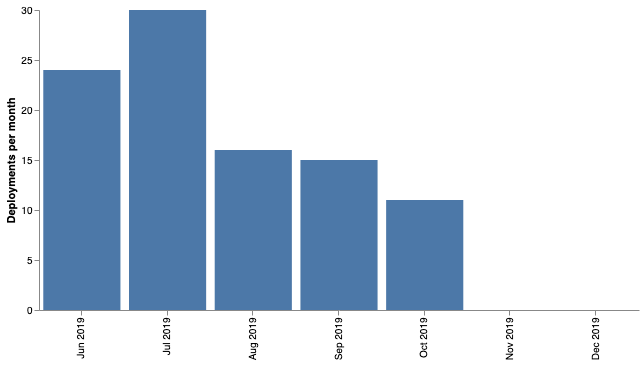

In [7]:
# We can now easily plot the deployment frequency

alt.Chart(
    releases.dataframes.code_folder_activity_count,
    width=600,
    height=300,
).mark_bar().encode(
    x=alt.X('yearmonth(date):O', axis=alt.Axis(title=None)),
    y=alt.Y('count:Q', axis=alt.Axis(title='Deployments per month')),
    tooltip=[alt.Tooltip('count:Q', title='Deployments')],
).configure_axis(grid=False).configure_view(strokeWidth=0)